In [2]:
import os
import numpy as np # linear algebra
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from skimage import io
import random
from matplotlib.image import imread
from sklearn.model_selection import train_test_split

In [3]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

In [4]:
len(os.listdir(train_path))

43

In [5]:
# os.listdir(train_path)

In [6]:
# os.listdir(train_path + '/7')

In [7]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [8]:
folders = os.listdir(train_path)

images_counts = { classes[int(folder)] : len(os.listdir(os.path.join(train_path, folder))) for folder in folders}
images_counts = sorted(images_counts.items(), key=lambda kv: (kv[1], kv[0]), reverse=True)


In [9]:
len(images_counts)

43

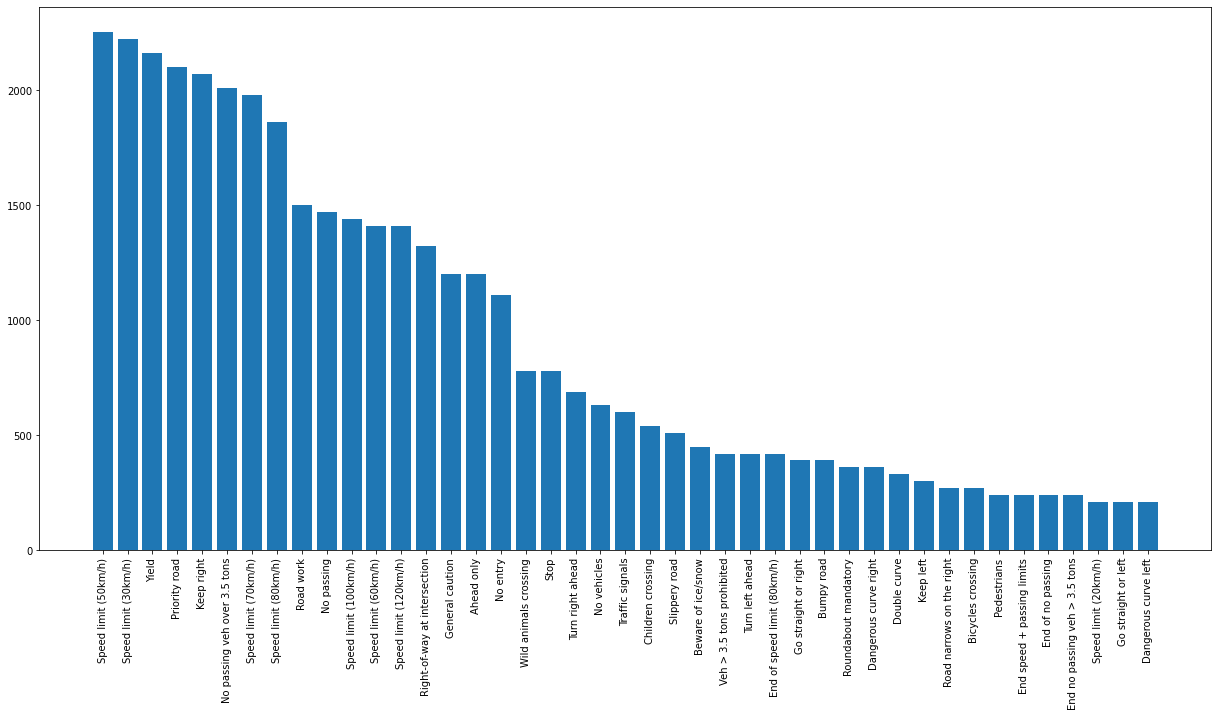

In [10]:
x = [ c[0] for c in images_counts]
y = [ c[1] for c in images_counts]
plt.figure(figsize=(21,10)) 
plt.bar(x, y)
plt.xticks(x, rotation='vertical')
plt.show()

In [11]:
os.listdir(test_path)

['Meta',
 'meta',
 'Meta.csv',
 'Train.csv',
 'Test.csv',
 'Test',
 'test',
 'Train',
 'train']

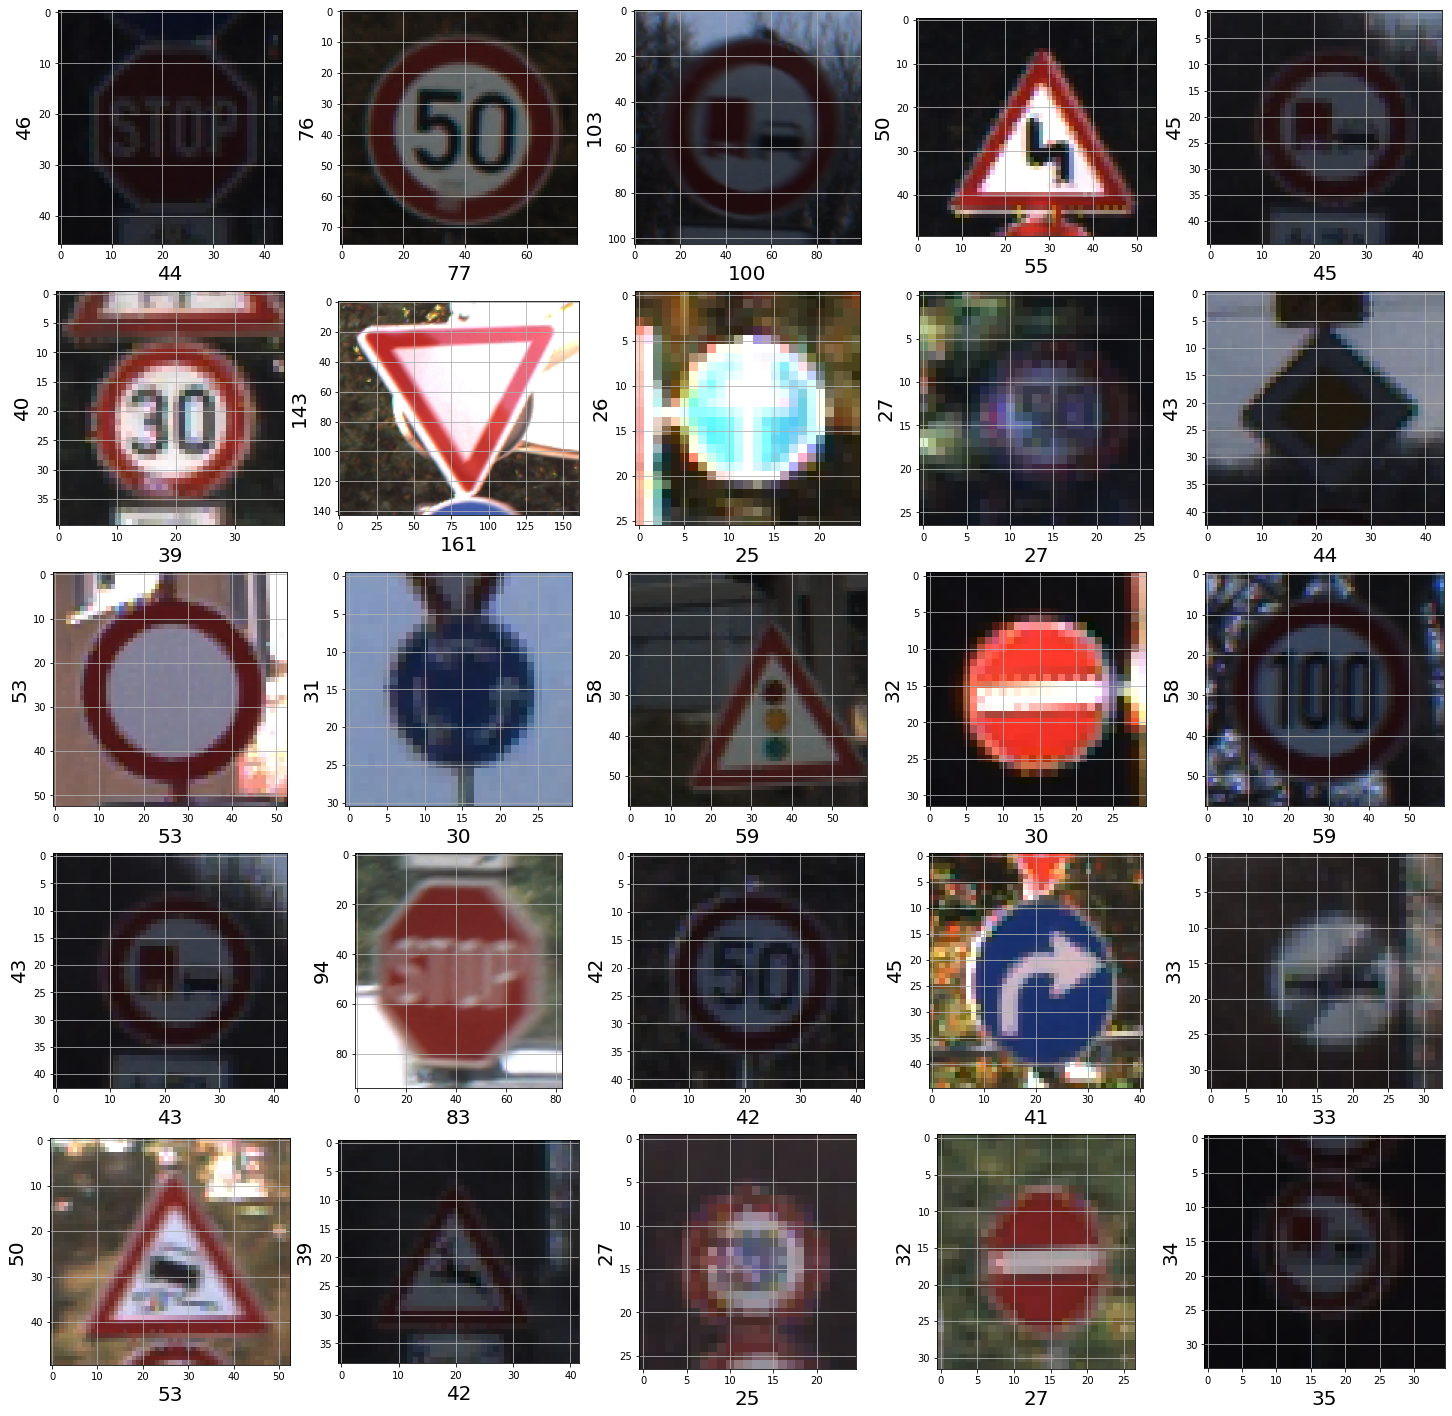

In [12]:
test_csv = pd.read_csv(f'{test_path}/Test.csv')
imgs = test_csv['Path'].values

plt.figure(figsize=(25,25))
for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = f"{test_path}/{random.choice(imgs)}"
    read_img = imread(random_img_path)
    plt.imshow(read_img)
    plt.grid(visible=None)
    plt.xlabel(read_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(read_img.shape[0], fontsize = 20)#height of image


In [13]:
class TrafficSignDataset:
    def __init__(self, images, labels, transform=None):
        self.transform = transform
        self.images = images
        self.labels = labels
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        img = io.imread(img_path)
        if self.transform:
            img = self.transform(img)
        return img, label 
    def __len__(self):
        return len(self.images)
    

In [14]:
def split_vals(a,n):
    return a[:n].copy(), a[n:].copy()

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((30, 30)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
images = []
labels = []
folders = os.listdir(train_path)
train_paths = [os.path.join(train_path, folder) for folder in folders]
for img_dir in train_paths:
    images += [os.path.join(img_dir, img) for img in os.listdir(img_dir)]
    labels += [int(img_dir.split('/')[-1])] * len(os.listdir(img_dir))


# n_valid = 1200
# n_trn = len(images) - n_valid
# X_train, X_valid = split_vals(images, n_trn)
# y_train, y_valid = split_vals(labels, n_trn)

X_train, X_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.10, random_state=42, shuffle=True)

traindataset = TrafficSignDataset(X_train ,y_train, transform=transform)
validdataset = TrafficSignDataset(X_valid ,y_valid, transform=transform)

In [16]:
len(X_train), len(X_valid), len(y_train), len(y_valid), len(images), len(labels)

(35288, 3921, 35288, 3921, 39209, 39209)

In [17]:
batch_size = 4
learning_rate = 0.01
num_epochs = 4

In [18]:
train_dataloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validdataset, batch_size=batch_size, shuffle=True)

In [19]:
len(traindataset), len(validdataset)

(35288, 3921)

In [20]:
traindataset[0][0].shape, validdataset[0][0].shape

(torch.Size([3, 30, 30]), torch.Size([3, 30, 30]))

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
### Resnet 18 32 51 100

In [23]:
class TrafficSignConv(nn.Module):
    def __init__(self) -> None:
        super(TrafficSignConv, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.fc1 = nn.Linear(12*6*6, 200)
        self.fc2 = nn.Linear(200, 43)
    
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 12*6*6)
        x = F.relu(self.fc1(x))
        x = (self.fc2(x))
        return x
        

In [24]:
model = TrafficSignConv().to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
n_total_steps = len(train_dataloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{n_total_steps}, Loss : {loss.item():.4f}")

        
        

Epoch 1/4, Step 1000/8822, Loss : 2.7692
Epoch 1/4, Step 2000/8822, Loss : 2.3190
Epoch 1/4, Step 3000/8822, Loss : 0.6386
Epoch 1/4, Step 4000/8822, Loss : 0.9525
Epoch 1/4, Step 5000/8822, Loss : 0.2835
Epoch 1/4, Step 6000/8822, Loss : 0.2151
Epoch 1/4, Step 7000/8822, Loss : 0.2810
Epoch 1/4, Step 8000/8822, Loss : 0.6151
Epoch 2/4, Step 1000/8822, Loss : 0.4543
Epoch 2/4, Step 2000/8822, Loss : 0.1655
Epoch 2/4, Step 3000/8822, Loss : 0.3424
Epoch 2/4, Step 4000/8822, Loss : 0.1770
Epoch 2/4, Step 5000/8822, Loss : 0.0208
Epoch 2/4, Step 6000/8822, Loss : 0.0130
Epoch 2/4, Step 7000/8822, Loss : 0.0407
Epoch 2/4, Step 8000/8822, Loss : 0.0109
Epoch 3/4, Step 1000/8822, Loss : 0.0965
Epoch 3/4, Step 2000/8822, Loss : 0.0101
Epoch 3/4, Step 3000/8822, Loss : 0.1387
Epoch 3/4, Step 4000/8822, Loss : 0.2796
Epoch 3/4, Step 5000/8822, Loss : 0.0837
Epoch 3/4, Step 6000/8822, Loss : 0.0002
Epoch 3/4, Step 7000/8822, Loss : 0.0380
Epoch 3/4, Step 8000/8822, Loss : 0.0001
Epoch 4/4, Step 

In [28]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

In [29]:
!ls

__notebook__.ipynb  model_scripted.pt


In [30]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for images,labels  in valid_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
#         print(torch.max(outputs.data, 1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 3924 test images: {100 * correct // total} %')


Accuracy of the network on the 3924 test images: 97 %


In [31]:
# Saving the trained model since the accuracy is very good
# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('model_scripted.pt') # Save

In [32]:
# model = torch.jit.load('model_scripted.pt')
# model.eval()